In [156]:
import cvxopt
import quadprog
import numpy as np
from numpy.linalg import inv
from cvxopt import matrix, solvers
from scipy.linalg import block_diag
import random
import qp_matrix
import matplotlib.pyplot as plt
import time
import math

In [157]:
# CVXOPT solver
def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = .5 * (P + P.T)  # make sure P is symmetric
    args = [matrix(P), matrix(q)]
    if G is not None:
        args.extend([matrix(G), matrix(h)])
        if A is not None:
            args.extend([matrix(A), matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((P.shape[1],))

In [158]:
def kinematics(x_init, y_init, theta_init, v,omega, dt):
    x = x_init+v*np.cos(theta_init)*dt
    y = y_init+v*np.cos(theta_init)*dt
    theta = theta_init+omega*dt
    return x,y,theta

In [159]:
def project_to_obstacles(x_in, y_in, x_obs, y_obs, r_obs, nsteps):
    x_proj = np.zeros(np.shape(x_in))
    y_proj = np.zeros(np.shape(y_in))

    for i in range(0, nsteps):
		#dist = sqrt(x^2 - y^2)
        dist = math.sqrt((x_in[i] - x_obs)**2 + (y_in[i] - y_obs)**2)
		#x_proj = x_o + r_o / dist * (x(i) - x_o)
        x_proj[i] = x_obs + r_obs / dist * (x_in[i] - x_obs)
		#y_proj = y_o + r_o / dist * (y(i) - y_o)
        y_proj[i] = y_obs + r_obs / dist * (y_in[i] - y_obs)
    return x_proj, y_proj

In [171]:
## MPC Solver

def MPC_solver_scx(init_pose,curr_pose,final_pose,obstacle,state,x_vel_limit,y_vel_limit,Np,Nc,dt):
    # Initialize at step i
    timer = time.time()
    
    x_origin = y_origin = -1
    x_limit = y_limit = 20 # box constraints?
    x_init, y_init, theta_init = init_pose
    x_curr, y_curr, theta_curr = curr_pose
    x_final, y_final, theta_final = final_pose
    x_obs, y_obs, r_obs = obstacle
    x_actual = -(x_final - x_curr) # What is x_actual?
    y_actual = -(y_final - y_curr)
    iter = 0
    d=1000
    delta = 0.5
    ## Equality and Inequality Constraint Matrices formulation

    # Declare Variable List
    A_eq_d=b_eq_d=A_ineq_d=B_ineq_d=big_H=big_h= np.empty(2) #formulate boundary inequalities and equalities (position & velocities)
    big_I = big_0= big_A_eq= dyn_A= dyn_b= term_A= term_b= x_pos_constraint= x_vel_constraint = np.empty(2)

    big_I = np.eye(2*Np)
    big_0 = np.zeros(2*Np)
    
    # Dynamic constraints
    dyn_A = np.column_stack((np.eye(Np, dtype=float) + np.eye(Np, Np , 1, dtype=float) * -1, np.eye(Np, dtype=float) * dt))
    dyn_b = np.zeros(Np, dtype=float)
    
    # Terminal LHS constraints
    term_A = np.zeros((2*Np), dtype=float)
    
    #Concatenate dynamic and terminal LHS constraint
    x_A_eq = np.row_stack((dyn_A, term_A))
    
    # Terminal Constraints
    x_term_b = np.array([x_actual])
    y_term_b = np.array([y_actual])
    
    # Concatenate dynamic and terminal RHS constraint
    x_b_eq = np.concatenate((dyn_b, x_term_b))
    y_b_eq = np.concatenate((dyn_b, y_term_b))
    big_b_eq = np.concatenate((x_b_eq, y_b_eq))
    
    # Inequality constraints(Boundary constraints)
    pos_x_constraint = np.eye(Np) * -delta + np.eye(Np, Np, 1)
    neg_x_constraint = np.eye(Np) * delta - np.eye(Np, Np, 1)
    x_pos_constraint = np.row_stack( (pos_x_constraint, neg_x_constraint) )

    pos_y_constraint = np.eye(Np) * -delta + np.eye(Np, Np, 1)
    neg_y_constraint = np.eye(Np) * delta - np.eye(Np, Np, 1)
    y_pos_constraint = np.row_stack((pos_y_constraint, neg_y_constraint))

    pos_r_vel_constraint = pos_theta_vel_constraint = np.eye(Np)
    neg_r_vel_constraint = neg_theta_vel_constraint = np.eye(Np) * -1

    x_vel_constraint = np.row_stack((pos_r_vel_constraint, neg_r_vel_constraint))
    x_Ba_ineq = block_diag(x_pos_constraint, x_vel_constraint)
    y_vel_constraints = np.row_stack((pos_theta_vel_constraint, neg_theta_vel_constraint))
    y_Ba_ineq = block_diag(y_pos_constraint, y_vel_constraints)
    
    x_vel_limit_vec = np.ones(2 * Np) * x_vel_limit
    y_vel_limit_vec = np.ones(2 * Np) * y_vel_limit
    
    r_Bb_ineq = np.concatenate((np.ones(Np) * ((x_origin + x_limit) * (1 - delta)),
                                np.ones(Np) * (-(x_origin - x_limit) *  (1 - delta)), x_vel_limit_vec))
    
    theta_Bb_ineq = np.concatenate((np.ones(Np) * ((y_origin + y_limit) * (1 - delta)), 
                                    np.ones(Np) * (-(y_origin - y_limit) *  (1 - delta)), y_vel_limit_vec))
    big_Bb_ineq = np.concatenate((r_Bb_ineq, theta_Bb_ineq))
    
    # Relaxation
    big_H = block_diag([1000], big_I, [1000], big_I)
    big_h = np.concatenate(([0], big_0, [0], big_0))
    x_A_eq = np.column_stack((np.zeros(Np + 1), x_A_eq))
    x_A_eq[Np-1][0] = -1
    x_A_eq[Np][1] = 1
    y_A_eq = x_A_eq
    big_A_eq = block_diag(x_A_eq, y_A_eq)

    x_Ba_ineq = np.column_stack((np.transpose(np.zeros(np.size(x_Ba_ineq, 0))), x_Ba_ineq))
    x_Ba_ineq[Np-1][0] = 1
    x_Ba_ineq[2 * Np-1][0] = -1

    y_Ba_ineq = np.column_stack((np.transpose(np.zeros(np.size(y_Ba_ineq, 0))), y_Ba_ineq))
    y_Ba_ineq[Np-1][0] = 1
    y_Ba_ineq[2 * Np-1][0] = -1

    big_Ba_ineq = block_diag(x_Ba_ineq, y_Ba_ineq)
    
#     print(big_H)
#     print((big_h))
#     print('big_Ba_ineq = ',big_Ba_ineq)
#     print('big_Bb_ineq = ',big_Bb_ineq)
#     print((big_A_eq))
#     print((big_b_eq))
#     print(np.shape(big_H))
#     print(np.shape(big_h))
#     print('shape(big_Ba_ineq)',np.shape(big_Ba_ineq))
#     print('shape(big_Bb_ineq)',np.shape(big_Bb_ineq))
#     print(np.shape(big_A_eq))
#     print(np.shape(big_b_eq))

    
    while (d>0.1 and iter<10):
        iter+=1
        barrier_cons_A = np.zeros((Np, 4 * Np + 2),dtype=float)
        barrier_cons_B = np.zeros((Np),dtype=float)
        
        x_in = state[1:Np+1]
        y_in = state[2 * Np + 2:2 * Np + 1 + Np + 1 ]
        
        A_ineq_d = big_Ba_ineq
        B_ineq_d = big_Bb_ineq - np.dot(A_ineq_d, state) #????

        A_eq_d = big_A_eq
        b_eq_d = big_b_eq - np.dot(big_A_eq, state) #????
        
#         x_proj = x_in
#         y_proj = y_in
        x_proj, y_proj = project_to_obstacles(x_in, y_in, x_obs, y_obs, r_obs, Np)
#         print('A_ineq_d = ',A_ineq_d)
#         print('b_ineq_d = ',B_ineq_d)
#         print('size A_ineq_d = ',A_ineq_d.shape)
#         print('size B_ineq_d = ',B_ineq_d.shape)
        
        # SCx Algorithm - Np steps
        for i in range(1,Np):
            x_prev = x_in[i-1]
            y_prev = y_in[i-1]
            x = x_in[i]
            y = y_in[i]
            
            # if h is negative, mule is outside obstacle
            # if h is 0, mule is grazing the obstacle, if h is positive, mule is inside the obstacle region.
            h_prev = r_obs**2 - (x_prev-x_obs)**2 - (y_prev-y_obs)**2 # distance to obstacle in the last time instant
            h = r_obs**2 - (x-x_obs)**2 - (y-y_obs)**2 # distance to obstacle in the current time instant

            gamma = 0.2 #Discount factor
            
            # Obstacle Constraints 
            barrier_cons_A[i][i+1] = -2*(x_proj[i]-x_obs)
            barrier_cons_A[i][1 + 2 * Np + 1 + i] = -2*(y_proj[i] - y_obs)

            barrier_cons_A[i][i] = gamma * 2 * (x_proj[i-1] - x_obs)
            barrier_cons_A[i][1 + 2 * Np + i] = gamma * 2 * (y_proj[i-1] - y_obs)
            barrier_cons_B[i] = - h + gamma * h_prev
        
        A_ineq_d = np.vstack((A_ineq_d, barrier_cons_A))
        B_ineq_d = np.concatenate((B_ineq_d, barrier_cons_B))
        
#     print('big_H = ',big_H)
#     print('big_h = ',big_h)
#     print('A_ineq_d = ',A_ineq_d)
#     print('B_ineq_d = ',B_ineq_d)
#     print('barrier_cons_A = ',barrier_cons_A)
#     print('barrier_cons_B = ',barrier_cons_B)
#     print('A_ineq_d = ',A_ineq_d)
#     print('B_ineq_d = ',B_ineq_d)
#     print('size A_ineq_d = ',A_ineq_d.shape)
#     print('size B_ineq_d = ',B_ineq_d.shape)
#     print('x_A_eq',x_A_eq)

#     d_state_out = cvxopt_solve_qp(big_H, big_h, A_ineq_d, B_ineq_d, A_eq_d, b_eq_d)
    d_state_out = qp_matrix.quadprog_solve_qp(big_H, big_h, A_ineq_d, B_ineq_d, A_eq_d, b_eq_d)
    
    state += d_state_out # state is getting updated here after the optimum solution is given by the solver.
    d = np.linalg.norm(state)
    print(time.time() - timer)
    return state[Np+1], state[3 *Np+2]

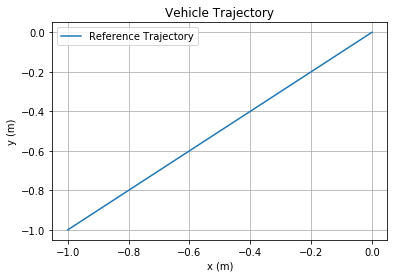

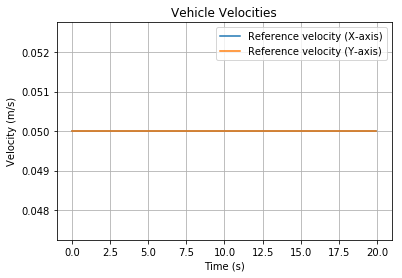

In [172]:
## Trajectory Formulation

# Initial Pose
init_pose = [-1,-1,np.pi/4]
# Final Pose
final_pose = [0,0,np.pi/4]
# Obstacle 
obstacle = [-0.75,-0.7,0.1] # x, y, radius

# MPC Parameters
Np = 5 # Not working for Np neq 1?!
Nc = Np
dt = 0.05 # Sample Time
t_final = 20
timeTaken = np.arange(0,t_final,dt)

# Input constraints
v_max = 3.0 # Forward velocity limit
v_min = 0 # Min Velocity
w_max = v_max/3 # Yaw rate limit
w_min = -v_max/3
# Velocity compoments
x_vel_limit = y_vel_limit= v_max # Vx_max, Vy_max
length=len(timeTaken)
# Planner Trajectory
speed = 1/t_final
path_planner = final_pose[0]*np.ones((length+2*Np,3),dtype=float).reshape(length+2*Np,3) # t_final
path_planner[0:length,0]=np.arange(init_pose[0],final_pose[0],abs(final_pose[0]-init_pose[0])/length) 
path_planner[0:length,1]=np.arange(init_pose[1],final_pose[1],abs(final_pose[1]-init_pose[1])/length)
velocity_planner = np.zeros((length+2*Np,2),dtype=float).reshape(length+2*Np,2)
velocity_planner[0:length,0] =speed*np.ones((length),dtype=float)
velocity_planner[0:length,1] =speed*np.ones((length),dtype=float)
iterations = len(timeTaken)

plt.figure()
plt.plot(path_planner[0:length+Np,0],path_planner[0:length+Np,1],label='Reference Trajectory')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Vehicle Trajectory')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(timeTaken,velocity_planner[0:length,0],label='Reference velocity (X-axis)')
plt.plot(timeTaken,velocity_planner[0:length,1],label='Reference velocity (Y-axis)')
# plt.plot(velocity_planner,label='Reference velocity (X-axis)')
# plt.plot(velocity_planner,label='Reference velocity (Y-axis)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Vehicle Velocities')
plt.legend()
plt.grid()
plt.show()

In [173]:
# Run MPC if obstacle detected
x_0, y_0,theta_0 = init_pose
x,y,theta=init_pose

Vx=np.zeros(iterations-Np+1)
Vy=np.zeros(iterations-Np+1)
dVx=np.zeros(iterations-Np+1)
dVy=np.zeros(iterations-Np+1)
X=np.zeros(iterations-Np+1)
Y=np.zeros(iterations-Np+1)
Theta = np.zeros(iterations-Np+1)
for i in range(0,iterations-Np+1,1): # Simulation till t_final
    state=np.zeros((4*Np+2),dtype=float)
    state[0] = path_planner[i+Np,0] # x(Np)
    state[1:Np+1] = np.array(path_planner[i:i+Np,0])
    state[Np+1:2*Np+1] = np.array(velocity_planner[i:i+Np,0])
    state[2*Np+1] = path_planner[i+Np,1] # y(Np)
    state[2*Np+2:3*Np+2] = np.array(path_planner[i:i+Np,1])
    state[3*Np+2:4*Np+2] = np.array(velocity_planner[i:i+Np,1])
    curr_pose = [x,y,theta]
    [dvx,dvy] = MPC_solver_scx(init_pose,curr_pose,final_pose,obstacle,state,x_vel_limit,y_vel_limit,Np,Nc,dt)
    vx=velocity_planner[i][0]
    vy=velocity_planner[i][1]
    dVx[i]=dvx 
    dVy[i]=dvy
    vx= vx+dvx
    vy= vy+dvy
    vx=min(v_max,max(vx,v_min))
    vy=min(v_max,max(vy,v_min))
    Vx[i]=vx 
    Vy[i]=vy
    x=x+dVx[i]*dt
    y=y+dVy[i]*dt
    X[i] = x
    Y[i] = y
    theta=np.arctan2(vy,vx)
    Theta[i] = theta

0.001332998275756836
0.0012066364288330078
0.0014600753784179688
0.0012118816375732422
0.0010852813720703125
0.0012583732604980469
0.0014331340789794922
0.0013530254364013672
0.001483917236328125
0.0011763572692871094
0.0010662078857421875
0.0013699531555175781
0.0013756752014160156
0.0010688304901123047
0.0010285377502441406
0.001138448715209961
0.001020193099975586
0.001176595687866211
0.0011775493621826172
0.0011703968048095703
0.0013201236724853516
0.0011649131774902344
0.001100301742553711
0.0010175704956054688
0.00113677978515625
0.0011892318725585938
0.0010886192321777344
0.0010221004486083984
0.0010466575622558594
0.0011601448059082031
0.0012178421020507812
0.0010993480682373047
0.0011355876922607422
0.0008881092071533203
0.0009844303131103516
0.0008871555328369141
0.0009062290191650391
0.0009143352508544922
0.0010678768157958984
0.0013532638549804688
0.0009708404541015625
0.0008592605590820312
0.0008862018585205078
0.0008740425109863281
0.0008873939514160156
0.0009579658508300

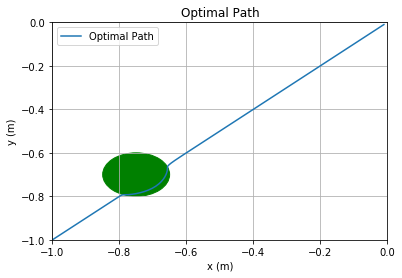

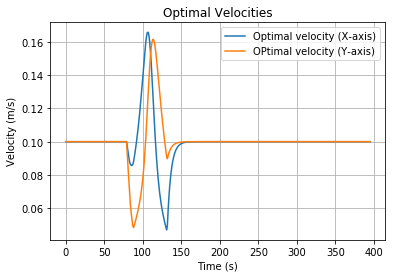

In [174]:
circle1 = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='g')
plt.figure()
# plt.axes().set_aspect('equal', 'datalim')
plt.plot(X,Y,label='Optimal Path')
plt.gcf().gca().add_artist(circle1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Optimal Path')
plt.ylim(-1, 0)
plt.xlim(-1, 0)
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(Vx,label='Optimal velocity (X-axis)')
plt.plot(Vy,label='OPtimal velocity (Y-axis)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Optimal Velocities')
plt.legend()
plt.grid()
plt.show()

In [169]:
curr_pose

[-0.9397591500961976, -0.9397591500961984, 0.0]

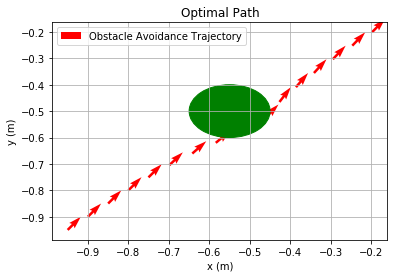

In [127]:
s = 1
circle1 = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='g')
plt.figure()
plt.gcf().gca().add_artist(circle1)
plt.quiver(X[::s],Y[::s], np.cos(Theta[::s]),np.sin(Theta[::s]),color='r',label='Obstacle Avoidance Trajectory')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Optimal Path')
plt.legend()
plt.grid()
plt.show()

No handles with labels found to put in legend.


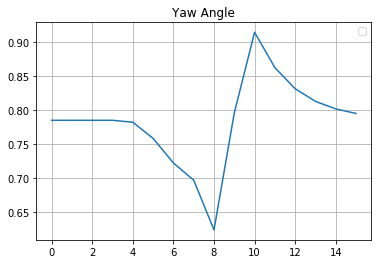

In [128]:
plt.figure()
plt.plot(Theta)
plt.title('Yaw Angle')
plt.legend()
plt.grid()
plt.show()